# import modules

In [1]:
import requests
import numpy as np
import pandas as pd
from pubchempy import Compound, get_compounds
from matplotlib import pyplot as plt
import seaborn as sns
from urllib import request
from brendapyrser import BRENDA
import html
import pickle
from math import exp
from feature_functions import *
import random
import re
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

In [2]:
brenda = BRENDA('../../local_data/brenda.txt')

In [3]:
def get_smiles(substrate):
    try :
        url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/%s/property/CanonicalSMILES/TXT'%substrate
        req = requests.get(url)
        if req.status_code != 200:
            smiles = 'NaN'
        else:
            smiles = req.content.splitlines()[0].decode()
    except :
        smiles = 'NaN'
    return smiles

def get_seq(ID):
    url = "https://www.uniprot.org/uniprot/%s.fasta" % ID
    try :
        data = requests.get(url)
        if data.status_code != 200:
            seq = 'NaN'
        else:
            seq =  "".join(data.text.split("\n")[1:])
    except :
        seq = 'NaN'
    return seq

def check_mutations(seq, mut_list):
    no_error = True
    for mut in mut_list:
        ind = int(mut[1:-1])-1
        old = mut[0].upper()
        if (ind > len(seq)-1) or (seq[ind] != old):
            no_error = False
            break
    return no_error

def apply_mutations(seq, mut_list):
    mut_seq = seq
    for mut in mut_list:
        ind = int(mut[1:-1])-1
        new = mut[-1].upper()
        temp_list = list(mut_seq)
        temp_list[ind] = new
        mut_seq = ''.join(temp_list)
    return mut_seq

# kcat unit: 1/s; Km unit: M; temperature unit: K

In [4]:
brenda_ec_list = []
for rxn in brenda.reactions:
    brenda_ec_list.append( rxn.ec_number )
brenda_ec_list = list(set(brenda_ec_list))
print(len(brenda_ec_list))

7609


In [5]:
QUERY_URL = 'http://sabiork.h-its.org/sabioRestWebServices/kineticlawsExportTsv'

with open('../data/enzyme.dat', 'r') as outfile :
    lines = outfile.readlines()

ec_list = []
for line in lines :
    if line.startswith('ID') :
        ec = line.strip().split('  ')[1]
        ec_list.append(ec.strip())
# print(ec_list)
print(len(ec_list))

7906


# download kcat data from brenda

In [14]:
def get_entry_kcat( ec ):
    r = brenda.reactions.get_by_id(ec)
    all_data = r.Kcatvalues
    result = []
    for sub in all_data.keys():
        sub_data = all_data[sub]
        for entry in sub_data:
            if ('Â°C' not in entry['meta'] ) or ( '#' not in entry['meta']) \
                        or (';' in entry['meta']) or ('specified' in entry['meta'] ):
                continue
            else:
                value = entry['value']
                temperature = html.unescape( entry['meta'].split('Â°C')[0] ) [-2:]
                try :
                    temperature = float(temperature)  
                except:
                    continue
                    
                if 'mutant' not in entry['meta']:
                    enz_type = 'WT'
                    mutation = 'None'
                else:
                    mut4 = re.findall('[A-Z][0-9][0-9][0-9][0-9][A-Z]',entry['meta'])
                    mut3 = re.findall('[A-Z][0-9][0-9][0-9][A-Z]',entry['meta'])
                    mut2 = re.findall('[A-Z][0-9][0-9][A-Z]',entry['meta'])
                    mut1 = re.findall('[A-Z][0-9][A-Z]',entry['meta'])
                    mut_list = mut4 + mut3 + mut2 + mut1
                    if len(mut_list) < 1:
                        continue
                    else:
                        enz_type = 'MUT'
                        mutation = '/'.join(mut_list) 
                    
                p_ref = entry['meta'].split('#')[1].strip()
                if ',' in p_ref:
                    p_ref_list = p_ref.split(',')
                else:
                    p_ref_list = [ p_ref ]
                p_ids = []
                for ref in p_ref_list:
                    p_ids.append( r.proteins[ref]['proteinID']  )
                    
                for p_id in p_ids:
                    if p_id == '':
                        continue
                    else:
                        result.append( {'EC':ec,'temperature':float(temperature),'sub': sub, 
                                'UniProtID':p_id,'EnzymeType':enz_type,'Mutation':mutation,'kcat': float(value) } )
    return result

In [15]:
result = []
idx = 0
for ec in brenda_ec_list:
    if idx % 500 == 0:
        print(str(idx) + ' done')
    result += get_entry_kcat( ec )
    idx+=1

0 done
500 done
1000 done
1500 done
2000 done
2500 done
3000 done
3500 done
4000 done
4500 done
5000 done
5500 done
6000 done
6500 done
7000 done
7500 done


In [16]:
rawdata_brenda = pd.DataFrame(result)
rawdata_brenda = (rawdata_brenda[rawdata_brenda['kcat']>0]).dropna().reset_index().drop(['index'],axis=1)
proteinIDs = []
for i in range(len(rawdata_brenda['UniProtID'])):
    ID = list( rawdata_brenda['UniProtID'] )[i]
    proteinIDs.append( ID.split(' ')[0] )
rawdata_brenda['UniProtID'] =  proteinIDs        

In [17]:
kcat_brenda = []
total = len(rawdata_brenda['sub'])

for i in range(len(rawdata_brenda['sub'])):
    ec, T, sub, pid, enz_type, muts, kcat = rawdata_brenda.iloc[i]
    data={'EC':ec,'Temp':T,'sub':sub,'ProtID':pid,'EnzymeType':enz_type,'Mutation':muts,'kcat':kcat}
    data['smiles']=get_smiles( sub )
    if data['smiles']  == 'NaN' or data['smiles'] == '':
        continue
    temp_seq = get_seq( pid )
    if temp_seq == 'NaN' or temp_seq == '':
        continue
    if enz_type == 'WT':
        data['seq'] = temp_seq
    else:
        mut_list = muts.split('/')
        if check_mutations(temp_seq, mut_list):
            temp_seq = apply_mutations(temp_seq, mut_list)
            data['seq'] = temp_seq
        else:
            continue
              
    kcat_brenda.append(data)
    if i%2000 == 0:
        print(str(i/total)+'% done')

0.0% done
0.18821757952192736% done
0.282326369282891% done
0.47054394880481837% done
0.564652738565782% done
0.846979107848673% done
0.9410878976096367% done


In [18]:
raw_kcat_brenda = pd.DataFrame( kcat_brenda )
raw_kcat_brenda = raw_kcat_brenda.dropna().reset_index().drop(['index'],axis=1)

In [19]:
raw_kcat_brenda.to_csv('../data/raw_kcat_brenda.csv',index = None)

# extract info from sabiork

In [20]:
# # download data from sabiork
# f = open('../data/raw_data.txt','w')
# i=0
# for ec in ec_list :
#     query_dict = {"ECNumber":'%s' %ec,}
#     query_string = ' AND '.join(['%s:%s' % (k,v) for k,v in query_dict.items()])
#     query = {'fields[]':['EntryID', 'Substrate', 'EnzymeType', 'PubMedID', 'Organism', 
#                          'UniprotID','ECNumber','Parameter','Temperature'], 'q':query_string}
#     request = requests.post(QUERY_URL, params = query)
#     results = request.text
#     if i >0:
#         results = results.replace("EntryID\tSubstrate\tEnzymeType\tPubMedID\tOrganism\tUniprotID\tECNumber\tparameter.type\tparameter.associatedSpecies\tparameter.startValue\tparameter.endValue\tparameter.standardDeviation\tparameter.unit\tTemperature\n",'')
#     f.write(results)
#     if i%100 == 0:
#         print(i)
#     i=i+1
# f.close()

In [21]:
#unit of kcat is 1/s
kcat_uni = []
with open('../data/raw_data.txt') as file:
    lines = file.readlines()
    for l in lines:
        l=l.replace('\n','').strip()
        params = l.split('\t')
        if len(params)!=14:
            continue
        if params[7] != 'kcat':
            continue
        if params[9] == '':
            continue
            
        data = {}
        data['Organism']=params[4]
        data['UniprotID']=params[5]
        data['EC']=params[6]
        data['Temperature']=params[13]
        if data['UniprotID'] == '-' or data['Temperature']=='-' or data['UniprotID'] == '' or data['Temperature']=='':
            continue
        
        if 'mutant' not in params[2]:
            enz_type = 'WT'
            mutation = 'None'
        else:
            mut4 = re.findall('[A-Z][0-9][0-9][0-9][0-9][A-Z]',params[2])
            mut3 = re.findall('[A-Z][0-9][0-9][0-9][A-Z]',params[2])
            mut2 = re.findall('[A-Z][0-9][0-9][A-Z]',params[2])
            mut1 = re.findall('[A-Z][0-9][A-Z]',params[2])
            mut_list = mut4 + mut3 + mut2 + mut1
            if len(mut_list) < 1:
                continue
            else:
                enz_type = 'MUT'
                mutation = '/'.join(mut_list)
        data['EnzymeType'] = enz_type
        data['Mutation'] = mutation
        if params[7] == 'kcat':
            if params[12]!='s^(-1)':
                continue
            #remove h2o and h+
            substrates = params[1].replace('H2O;','').replace(';H2O','').replace('H+;','').replace(';H+','')
            #remove cofactors
            cofactors = ['FADH2','FAD','NAD+','NADH']
            if ';' in substrates:
                for cof in cofactors:
                    substrates = substrates.replace(';'+cof,'').replace(cof+';','')
                    
            subs = substrates.split(';')
            
            if len(subs) == 1:
                data['sub']=subs[0]
                data['kcat']=params[9]
                data['unit']=params[12]
                kcat_uni.append(data)      
        else:
            continue           

In [22]:
kcat_table_uni = pd.DataFrame(kcat_uni).dropna()
kcat_table_uni = kcat_table_uni.dropna().drop_duplicates().reset_index().drop(['index'],axis=1)

# Process kcat from sabiork

In [23]:
uni = []
total = len(kcat_table_uni['sub'])

for i in range(len(kcat_table_uni['sub'])):
    if i%1000 == 0:
        print( str(i/total)+'% done' ) 
        
    data={'EC':list(kcat_table_uni['EC'])[i],'Temp':float( list(kcat_table_uni['Temperature'])[i] ),
          'kcat':float( list(kcat_table_uni['kcat'])[i]), 'sub':list(kcat_table_uni['sub'])[i],
          'ProtID': list(kcat_table_uni['UniprotID'])[i], 'EnzymeType':list(kcat_table_uni['EnzymeType'])[i],
          'Mutation':list(kcat_table_uni['Mutation'])[i] }
    
    data['smiles']=get_smiles( list(kcat_table_uni['sub'])[i] )
    if data['smiles'] == 'NaN' or data['smiles'] == '':
        continue
    temp_seq =get_seq( list(kcat_table_uni['UniprotID'])[i] )
    if temp_seq == 'NaN' or temp_seq == '':
        continue
        
    if data['EnzymeType'] == 'WT':
        data['seq'] = temp_seq
    else:
        mut_list = data['Mutation'].split('/')
        if check_mutations(temp_seq, mut_list):
            temp_seq = apply_mutations(temp_seq, mut_list)
            data['seq'] = temp_seq
        else:
            continue
        
    uni.append(data)

0.0% done
0.10334849111202976% done
0.20669698222405952% done
0.3100454733360893% done
0.41339396444811904% done
0.5167424555601489% done
0.6200909466721786% done
0.7234394377842084% done
0.8267879288962381% done
0.9301364200082679% done


In [24]:
uni_table=pd.DataFrame(uni)
uni_table = uni_table.dropna().drop_duplicates().reset_index().drop(['index'],axis=1)
uni_table.to_csv('../data/raw_kcat_sa.csv',index=None)

# merge kcat data from brenda and sabiork
## - check conflicts(pick the largest one), kcat > 0, unique compound-protein pairs

In [16]:
raw_kcat_brenda = pd.read_csv('../data/raw_kcat_brenda.csv')
raw_kcat_brenda = raw_kcat_brenda[['EC','sub', 'ProtID', 'EnzymeType', 'Mutation',
                                   'kcat','Temp','smiles', 'seq']]
raw_kcat_brenda['source'] = ['brenda' for i in range(len(raw_kcat_brenda['EC']))]
print( len(raw_kcat_brenda['EC']) )
raw_kcat_sa = pd.read_csv('../data/raw_kcat_sa.csv')
raw_kcat_sa = raw_kcat_sa[['EC','sub', 'ProtID', 'EnzymeType', 'Mutation',
                                   'kcat','Temp','smiles', 'seq']]
raw_kcat_sa['source'] = ['sabiork' for i in range(len(raw_kcat_sa['EC']))]
print( len(raw_kcat_sa['EC']) )

kcat_merge =  (pd.concat([raw_kcat_sa,raw_kcat_brenda]) ).reset_index().drop(['index'],axis=1)
print( len(kcat_merge['EC']) )

14852
6129
20981


In [17]:
keep_uni = []
for i in range( len(kcat_merge['EC']) ):
    T, smiles, seq = list(kcat_merge['Temp'])[i], list(kcat_merge['smiles'])[i], list(kcat_merge['seq'])[i]
    temp_table = kcat_merge[ (kcat_merge['Temp']==T)&(kcat_merge['smiles']==smiles)&(kcat_merge['seq']==seq)]
    temp_table = temp_table.sort_values(by=['kcat'],ascending=False)
    keep_uni.append(temp_table.index[0])
keep_uni = list(set(keep_uni))
kcat_merge = ( kcat_merge.iloc[keep_uni] ).reset_index().drop(['index'],axis=1)
print( len(kcat_merge['EC']) )

16430


In [18]:
TC_list = list(kcat_merge['Temp'])
kcat_merge['Inv_Temp'] = [ 1/float(T+273.15) for T in TC_list]

In [19]:
kcat_merge = kcat_merge[ ['EC', 'sub', 'ProtID', 'EnzymeType', 'Mutation', 'kcat', 'Temp', 'Inv_Temp',
       'smiles', 'seq', 'source'] ]
kcat_merge.head()

,EC,sub,ProtID,EnzymeType,Mutation,kcat,Temp,Inv_Temp,smiles,seq,source
0,1.1.1.1,Ethanol,P49384,WT,None,408.33330,25.0,0.003354,CCO,MLRLTSARSIVSPLRKGAFGSIRTLATSVPETQKGVIFYENGGKLE...,sabiork
1,1.1.1.1,Acetaldehyde,P49384,WT,None,1143.33300,25.0,0.003354,CC=O,MLRLTSARSIVSPLRKGAFGSIRTLATSVPETQKGVIFYENGGKLE...,sabiork
2,1.1.1.1,1-Butanol,P06757,WT,None,14.33333,25.0,0.003354,CCCCO,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork
3,1.1.1.1,Butanal,P06757,WT,None,156.00000,25.0,0.003354,CCCC=O,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork
4,1.1.1.1,1-Octanal,P06757,WT,None,390.00000,25.0,0.003354,CCCCCCCC=O,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork


# Remove metal ions and smiles with isolated parts from entries

In [20]:
ions = ['[Fe+3]','[Fe+2]','[Zn+2]','[Cu+2]','[K+]','[Ca+2]','[Hg+2]','[Mg+2]','[Mn+2]','[Mg+2]','[S-2]',
              '[Cd+2]','[Co+2]','[Ag+]','[Cr+6]','[Cs+]','[F-]','[Br-]','[Cl-]','[I-]','[Na+]','[Ni+2]','[No]','[Mo]']
rm_ind = []
for i in range( len(kcat_merge['smiles']) ):
    if '.' in list( kcat_merge['smiles'] )[i]:
        rm_ind.append(i)
        continue
        
    for ion in ions:
        if ion in list( kcat_merge['smiles'] )[i]:
            rm_ind.append(i)
rm_ind = list(set(rm_ind))
kcat_merge = ( kcat_merge.drop(rm_ind) ).reset_index().drop(['index'],axis=1) 

In [21]:
kcat_merge =( kcat_merge[kcat_merge['kcat']>0]).reset_index().drop(['index'],axis=1) 
print( len(kcat_merge['EC']) )

16249


In [23]:
# kcat_merge.to_csv('../data/kcat_merge.csv',index=None)

# Additional molecular properties of substrates (x)
* MW, logP, MR, TPSA, labuteasa, fractioncsp3, hba, hbd;

In [24]:
# kcat_merge = pd.read_csv('../data/kcat_merge.csv')
# print(kcat_merge.columns)
# kcat_merge.head()

In [24]:
# def calc_addifeatures(smiles):
#     mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
#     mw = Chem.rdMolDescriptors.CalcExactMolWt(mol)
#     logp, mr = Chem.rdMolDescriptors.CalcCrippenDescriptors(mol)
#     tpsa = Chem.rdMolDescriptors.CalcTPSA(mol)
#     labuteasa = Chem.rdMolDescriptors.CalcLabuteASA(mol)
#     fcsp3 = Chem.rdMolDescriptors.CalcFractionCSP3(mol)
#     hba = Chem.rdMolDescriptors.CalcNumLipinskiHBA(mol)
#     hbd = Chem.rdMolDescriptors.CalcNumLipinskiHBD(mol)
#     return {'mw':mw, 'logp':logp, 'mr':mr, 'tpsa':tpsa, 'labuteasa':labuteasa, 
#             'fcsp3':fcsp3, 'hba':hba, 'hbd':hbd}

In [26]:
# addi_features = []
# for i in range(len(kcat_merge['smiles'])):
#     smiles = list( kcat_merge['smiles'] )[i]
#     addi_features.append( calc_addifeatures(smiles) )
# addi_table = pd.DataFrame(addi_features)
# print(addi_table.columns)

In [25]:
# kcat_merge = pd.concat([kcat_merge,addi_table],axis=1)
# kcat_merge = kcat_merge[['EC', 'sub', 'ProtID', 'EnzymeType', 'Mutation', 'smiles', 'seq','Temp',\
#                          'mw', 'logp', 'mr', 'tpsa', 'labuteasa', 'fcsp3', 'hba', 'hbd','kcat', 'source']]
# EC = [x.replace('()','').strip() for x in list(kcat_merge['EC'])]
# kcat_merge['EC'] = EC
# kcat_merge.head()

# Assign enzyme pathways

In [9]:
kcat_merge = pd.read_csv('../data/kcat_merge.csv')
TC_list = list(kcat_merge['Temp'])
kcat_merge['Temp_K'] = [ float(T+273.15) for T in TC_list]
kcat_merge = kcat_merge[ ['EC', 'sub', 'ProtID', 'EnzymeType', 'Mutation', 'kcat', 'Temp', 'Temp_K',
       'Inv_Temp', 'smiles', 'seq', 'source']]
EC = [x.replace('()','').strip() for x in list(kcat_merge['EC'])]
kcat_merge['EC'] = EC
kcat_merge.head()

,EC,sub,ProtID,EnzymeType,Mutation,kcat,Temp,Temp_K,Inv_Temp,smiles,seq,source
0,1.1.1.1,Ethanol,P49384,WT,None,408.33330,25.0,298.15,0.003354,CCO,MLRLTSARSIVSPLRKGAFGSIRTLATSVPETQKGVIFYENGGKLE...,sabiork
1,1.1.1.1,Acetaldehyde,P49384,WT,None,1143.33300,25.0,298.15,0.003354,CC=O,MLRLTSARSIVSPLRKGAFGSIRTLATSVPETQKGVIFYENGGKLE...,sabiork
2,1.1.1.1,1-Butanol,P06757,WT,None,14.33333,25.0,298.15,0.003354,CCCCO,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork
3,1.1.1.1,Butanal,P06757,WT,None,156.00000,25.0,298.15,0.003354,CCCC=O,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork
4,1.1.1.1,1-Octanal,P06757,WT,None,390.00000,25.0,298.15,0.003354,CCCCCCCC=O,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork


In [10]:
ec_module = pd.read_csv('../data/module_ec.txt',sep='\t',header=None)
ec_module = ec_module.drop([0],axis=1)
ec_module = ec_module.rename(columns = {1:'EC',2:'Pathway'})
print(np.unique(ec_module['Pathway']) )
enz_paths = {'Primary':set(),'Secondary':set()}
for i in range( len(ec_module['EC']) ):
    ec = list(ec_module['EC'])[i].replace('EC','').strip()
    if 'Primary' in list(ec_module['Pathway'])[i]:
        enz_paths['Primary'].add(ec)
    else:
        enz_paths['Secondary'].add(ec)

['Intermediate' 'Primary - Carbohydrate & Energy Metabolism'
 'Primary - amino acids, fatty acids and nucleotides' 'Secondary'
 'Secondary_other' 'x']


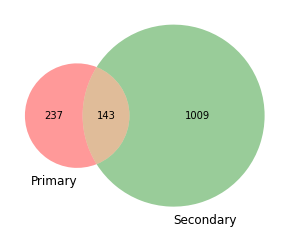

In [11]:
from matplotlib_venn import venn2
venn2([enz_paths['Primary'],enz_paths['Secondary']], ['Primary','Secondary'])

In [12]:
pathway = []
for i in range(len(kcat_merge['EC'])):
    if list( kcat_merge['EC'] )[i] in enz_paths['Primary']:
        pathway.append('Primary')
    elif list( kcat_merge['EC'] )[i] not in (enz_paths['Primary'] | enz_paths['Secondary']):
        pathway.append('Un-annotated')
    else:
        pathway.append('Secondary')
kcat_merge['pathway'] = pathway
kcat_merge.head()      

,EC,sub,ProtID,EnzymeType,Mutation,kcat,Temp,Temp_K,Inv_Temp,smiles,seq,source,pathway
0,1.1.1.1,Ethanol,P49384,WT,None,408.33330,25.0,298.15,0.003354,CCO,MLRLTSARSIVSPLRKGAFGSIRTLATSVPETQKGVIFYENGGKLE...,sabiork,Secondary
1,1.1.1.1,Acetaldehyde,P49384,WT,None,1143.33300,25.0,298.15,0.003354,CC=O,MLRLTSARSIVSPLRKGAFGSIRTLATSVPETQKGVIFYENGGKLE...,sabiork,Secondary
2,1.1.1.1,1-Butanol,P06757,WT,None,14.33333,25.0,298.15,0.003354,CCCCO,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork,Secondary
3,1.1.1.1,Butanal,P06757,WT,None,156.00000,25.0,298.15,0.003354,CCCC=O,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork,Secondary
4,1.1.1.1,1-Octanal,P06757,WT,None,390.00000,25.0,298.15,0.003354,CCCCCCCC=O,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork,Secondary


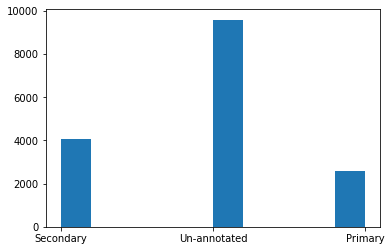

In [13]:
plt.hist(kcat_merge['pathway']);

In [14]:
# kcat_merge.to_csv('../data/kcat_merge.csv',index=None)

# Random oversampling entries of low and high temperatures
* 6000 duplicates for T >= 40C
* 2000 duplicates for T <= 20C

In [2]:
kcat_merge = pd.read_csv('../data/kcat_merge.csv')

In [4]:
# high_set = (kcat_merge[kcat_merge['Temp']>=40]).reset_index().drop(['index'],axis=1)
# low_set = (kcat_merge[kcat_merge['Temp']<=20]).reset_index().drop(['index'],axis=1)
# over_low, over_high = [],[]
# for i in range( 2*len(high_set.index) ):
#     rand_idx = np.random.randint( len(high_set['EC'] ) - 1,size=1)[0]
#     temp_data = dict( high_set.iloc[rand_idx] )
#     over_high.append( temp_data )
# for i in range( 2*len(low_set.index) ):
#     rand_idx = np.random.randint( len(low_set['EC'] ) - 1,size=1)[0]
#     temp_data = dict( low_set.iloc[rand_idx] )
#     over_low.append( temp_data )
# over_set = over_low + over_high
# random.shuffle(over_set)
# over_pd = pd.DataFrame(over_set)

In [10]:
# process_pd = ( pd.concat([ kcat_merge, over_pd]) ).reset_index().drop(['index'],axis=1)
# T_K_norm = scale_minmax(process_pd['Temp_K'], min(process_pd['Temp_K']) , max(process_pd['Temp_K']))
# inv_T_norm = scale_minmax(process_pd['Inv_Temp'], min(process_pd['Inv_Temp']) , max(process_pd['Inv_Temp']))
# process_pd['Temp_K_norm'] = T_K_norm
# process_pd['Inv_Temp_norm'] = inv_T_norm

In [2]:
process_pd = pd.read_csv('../data/processed_data.csv')
process_pd.head()

,EC,sub,ProtID,EnzymeType,Mutation,kcat,Temp,Temp_K,Inv_Temp,smiles,seq,source,pathway,Temp_K_norm,Inv_Temp_norm
0,1.1.1.1,Ethanol,P49384,WT,None,408.33330,25.0,298.15,0.003354,CCO,MLRLTSARSIVSPLRKGAFGSIRTLATSVPETQKGVIFYENGGKLE...,sabiork,Secondary,0.25,0.687112
1,1.1.1.1,Acetaldehyde,P49384,WT,None,1143.33300,25.0,298.15,0.003354,CC=O,MLRLTSARSIVSPLRKGAFGSIRTLATSVPETQKGVIFYENGGKLE...,sabiork,Secondary,0.25,0.687112
2,1.1.1.1,1-Butanol,P06757,WT,None,14.33333,25.0,298.15,0.003354,CCCCO,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork,Secondary,0.25,0.687112
3,1.1.1.1,Butanal,P06757,WT,None,156.00000,25.0,298.15,0.003354,CCCC=O,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork,Secondary,0.25,0.687112
4,1.1.1.1,1-Octanal,P06757,WT,None,390.00000,25.0,298.15,0.003354,CCCCCCCC=O,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork,Secondary,0.25,0.687112


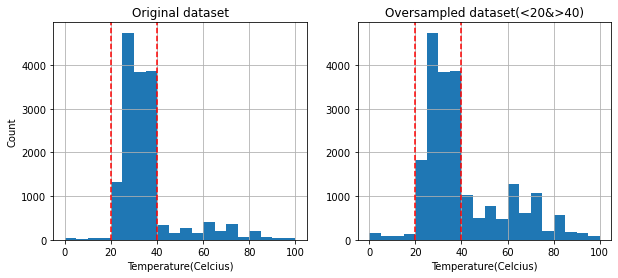

In [12]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].hist(kcat_merge['Temp'],bins=20);
axs[1].hist(process_pd['Temp'],bins=20);
axs[0].set_title('Original dataset')
axs[0].set_ylabel('Count')
axs[1].set_title('Oversampled dataset(<20&>40)')
for ax in axs:
    ax.set_xlabel('Temperature(Celcius)')
    ax.axvline(x=20,color='r', linestyle='--')
    ax.axvline(x=40,color='r', linestyle='--')
    ax.grid()

In [14]:
# process_pd.to_csv('../data/processed_data.csv',index=None)

# Dataset split

In [5]:
process_pd = pd.read_csv('../data/processed_data.csv')
process_pd.head()

,EC,sub,ProtID,EnzymeType,Mutation,kcat,Temp,Temp_K,Inv_Temp,smiles,seq,source,pathway,Temp_K_norm,Inv_Temp_norm
0,1.1.1.1,Ethanol,P49384,WT,None,408.33330,25.0,298.15,0.003354,CCO,MLRLTSARSIVSPLRKGAFGSIRTLATSVPETQKGVIFYENGGKLE...,sabiork,Secondary,0.25,0.687112
1,1.1.1.1,Acetaldehyde,P49384,WT,None,1143.33300,25.0,298.15,0.003354,CC=O,MLRLTSARSIVSPLRKGAFGSIRTLATSVPETQKGVIFYENGGKLE...,sabiork,Secondary,0.25,0.687112
2,1.1.1.1,1-Butanol,P06757,WT,None,14.33333,25.0,298.15,0.003354,CCCCO,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork,Secondary,0.25,0.687112
3,1.1.1.1,Butanal,P06757,WT,None,156.00000,25.0,298.15,0.003354,CCCC=O,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork,Secondary,0.25,0.687112
4,1.1.1.1,1-Octanal,P06757,WT,None,390.00000,25.0,298.15,0.003354,CCCCCCCC=O,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork,Secondary,0.25,0.687112


In [8]:
ratio = 0.1
idx = np.arange( len( process_pd['EC']) )
np.random.shuffle(idx)
num_split = int( len( process_pd['EC']) * ratio)
idx_test, idx_train = idx[:num_split], idx[num_split:]
test_data, train_data = process_pd.iloc[idx_test].reset_index().drop(['index'],axis=1),\
                        process_pd.iloc[idx_train].reset_index().drop(['index'],axis=1) 

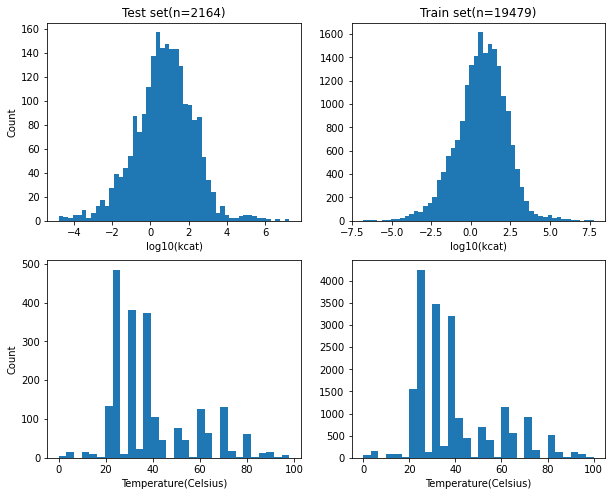

In [13]:
fig, axs = plt.subplots(2,2,figsize=(10,8))
axs[0][0].hist(np.log10(test_data['kcat']),bins=50 );
axs[0][1].hist( np.log10(train_data['kcat']),bins=50 );
for ax in axs[0]:
    ax.set_xlabel('log10(kcat)')
axs[0][0].set_ylabel('Count')
axs[0][0].set_title('Test set(n=2164)');
axs[0][1].set_title('Train set(n=19479)');
axs[1][0].hist(test_data['Temp'],bins=30 );
axs[1][1].hist(train_data['Temp'],bins=30 );
axs[1][0].set_ylabel('Count');
for ax in axs[1]:
    ax.set_xlabel('Temperature(Celsius)')

In [16]:
# test_data.to_csv('../data/test_data.csv',index=None)
# train_data.to_csv('../data/train_data.csv',index=None)

# Hyperparameters

In [4]:
# default_dict = { 'comp_dim': 80, 'prot_dim': 80, 'gat_dim': 50, 
#                 'num_head': 3, 'dropout': 0.1, 'alpha': 0.1, 
#                 'window':5, 'layer_cnn': 4, 'latent_dim': 80, 'layer_out': 4}

In [9]:
# dump_pickle(default_dict, '../data/hyparams/default.pkl')

In [10]:
# param_list = []

# for ld in [40,64]:
#     for num_out in [3,4,5,6]:
#         temp_param = default_dict.copy()
#         temp_param['latent_dim'] = ld
#         temp_param['layer_out'] = num_out
#         param_list.append( temp_param )

In [12]:
# for i in range(len(param_list)):
#     dump_pickle( param_list[i], '../data/hyparams/param_'+str(i+1)+'.pkl')

In [5]:
# for num_out in [8,10,12]:
#     temp_param = default_dict.copy()
#     temp_param['latent_dim'] = 64
#     temp_param['layer_out'] = num_out
#     dump_pickle( temp_param, '../data/hyparams/param_layerout'+str(num_out)+'.pkl')

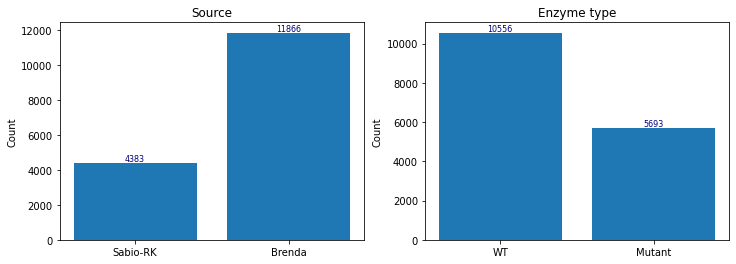

In [35]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
bars = axs[0].bar(['Sabio-RK','Brenda'],
           [list(kcat_merge['source']).count('sabiork'), list(kcat_merge['source']).count('brenda')])
axs[0].bar_label(bars, fontsize=8, color='navy')
axs[0].set_title('Source')

bars = axs[1].bar(['WT','Mutant'],
        [list(kcat_merge['EnzymeType']).count('WT'), list(kcat_merge['EnzymeType']).count('MUT')])
axs[1].bar_label(bars, fontsize=8, color='navy')
axs[1].set_title('Enzyme type')

for ax in axs:
    ax.set_ylabel('Count')